# Homework #2: Music Auto Tagging (Multi-Label Classification)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

## Importing Packages

In [1]:
# # Download the dataset (3GB)
# !wget http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv
# !gdown --id 1f_kUF9nTLFI0pJaZxm6YNt4t_J6-Q-dg

In [2]:
# %%capture
# !tar -xvf gct634.tar.gz

In [3]:
# # Install libraries
# %pip install torchaudio-augmentations

In [4]:
import warnings
import multiprocessing
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm.notebook import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import IPython.display as ipd

In [5]:
# For reproducibility
random_seed = 1 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# Data Checking


In [6]:
# use 50 top tags
TAGS = ['guitar','classical', 'slow','techno','strings','drums','electronic','rock',
        'fast','piano','ambient','beat','violin','vocal','synth','female','indian',
        'opera','male','singing','vocals','no vocals','harpsichord','loud','quiet',
        'flute', 'woman', 'male vocal', 'no vocal', 'pop','soft','sitar', 'solo',
        'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice',
        'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country',
        'metal', 'female voice', 'choral']

In [7]:
df = pd.read_csv("./annotations_final.csv", sep="\t", index_col=0)
item = df.iloc[0]
item[item != 0] # check annotated tags

classical                                                    1
strings                                                      1
opera                                                        1
violin                                                       1
mp3_path     f/american_bach_soloists-j_s__bach_solo_cantat...
Name: 2, dtype: object

In [8]:
# filter out, un-annnotated dataset
df_filter = df[TAGS].sum(axis=1)
use_id = df_filter[df_filter != 0].index
df = df.loc[use_id]

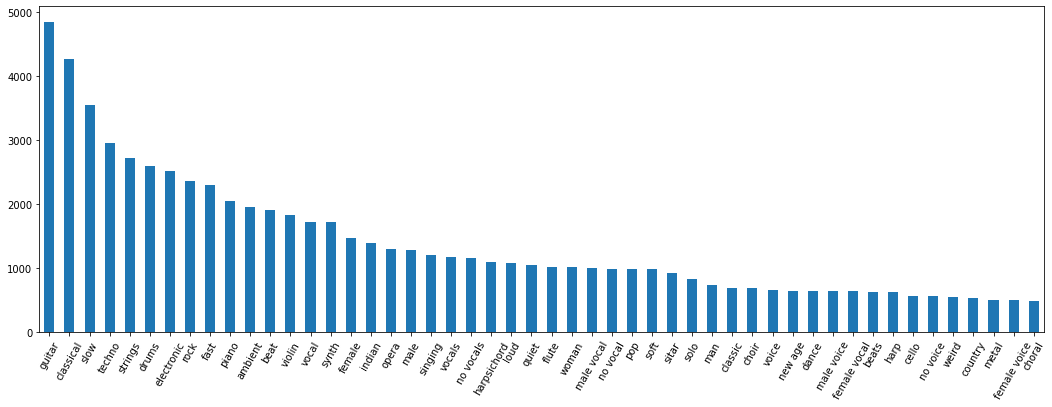

In [9]:
df[TAGS].sum().plot.bar(figsize=(18,6),rot=60) # check data distribution

In [10]:
len(df)

21111

# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [11]:
train = []
valid = []
test = []
id_to_path = {}
for idx in range(len(df)):
  item = df.iloc[idx]
  id = item.name
  path = item['mp3_path']
  folder = path.split("/")[0]
  id_to_path[id] = path
  if folder in "012ab":
    train.append(id)# split = "train"
  elif folder == "c":    
    valid.append(id)# split = "valid"
  elif folder in "d":
    test.append(id)# split = "test"

In [12]:
total = len(train) + len(valid) + len(test)
total, len(train) / total, len(valid)/ total, len(test)/ total

(9074, 0.6839321137315406, 0.16850341635441923, 0.14756446991404013)

In [13]:
df = df[TAGS]

In [14]:
df_train = df.loc[train]
df_valid = df.loc[valid]
df_test = df.loc[test]

In [15]:
# Data processing setup.
SR = 16000
BATCH_SIZE = 16

## Dataset & DataLoader

In [16]:
import random
from torch.utils.data import Dataset, DataLoader
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)

class AudioDataset(Dataset):
    def __init__(self, paths, input_length, binary, id_to_path, split, is_augmentation=False):
        self.paths = paths
        self.input_length = input_length
        self.binary = binary
        self.id_to_path = id_to_path
        self.split = split
        self.is_augmentation = is_augmentation
        if is_augmentation:
            self._get_augmentations()

    def _get_augmentations(self):
        transforms = [
            RandomApply([PolarityInversion()], p=0.8),
            #RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            #RandomApply([HighLowPass(sample_rate=16000)], p=0.1),
            #RandomApply([Delay(sample_rate=16000)], p=0.1),
            RandomApply([PitchShift(n_samples=9074 * 16000, sample_rate=16000)], p=0.4),
            #RandomApply([Reverb(sample_rate=16000)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def __getitem__(self, index):
        item = self.binary.iloc[index]
        waveform = self.item_to_waveform(item)
        if self.is_augmentation:
            waveform = self.augmentation(torch.from_numpy(waveform)).numpy()
        return waveform.astype(np.float32), item.values.astype(np.float32)

    def item_to_waveform(self, item):
        id = item.name
        path = os.path.join(self.paths,
                            self.id_to_path[id].replace(".mp3", ".npy"))  # pre-extract waveform, for fast loader
        waveform = np.load(path)
        if self.split in ['TRAIN', 'VALID']:
            random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
            waveform = waveform[random_idx:random_idx + self.input_length]  # extract input
            audio = np.expand_dims(waveform, axis=0)  # 1 x samples
        elif self.split == 'TEST':
            sample_rate = 16000
            duration = 3
            input_length = sample_rate * duration
            chunk_number = waveform.shape[0] // self.input_length
            chunk = np.zeros((chunk_number, self.input_length))
            for idx in range(chunk.shape[0]):
                chunk[idx] = waveform[idx:idx + input_length]
            audio = chunk
        return audio

    def __len__(self):
        return len(self.binary)


### Computing statistics of the training set
The code below compute mean, standard deviation and the minimum temporal dimension size, and use them for preprocessing inputs.

In [17]:
BATCH_SIZE = 16
num_workers = 2
sample_rate = 16000
duration = 3
input_length =  sample_rate * duration
data_path = "./waveform"
tr_data = AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN', is_augmentation=True)
va_data = AudioDataset(data_path, input_length, df_valid, id_to_path, 'VALID')
te_data = AudioDataset(data_path, input_length, df_test, id_to_path, 'TEST')
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [18]:
# Source: https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='none'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.binary_cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [19]:
class Runner(object):
  def __init__(self, model, lr, momentum, weight_decay, sr, tags):
    self.optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = FocalLoss().to(self.device)
    #self.criterion = torch.nn.BCELoss().to(self.device)
    self.tags = tags

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for x, y in pbar:
      # Move mini-batch to the desired device.
      x = x.to(self.device)
      y = y.to(self.device)
      # Feed forward the model.
      prediction = self.model(x)
      # Compute the loss.
      loss = self.criterion(prediction, y)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    predictions = []
    labels = []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for x, y in pbar:
      x = x.to(self.device)
      y = y.to(self.device)
      x = x.transpose(1,0) # pre-batch in audio loader (chunk, 1, waveform)
      prediction = self.model(x)
      prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
      loss = self.criterion(prediction, y) 
      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
      predictions.extend(prediction.detach().cpu().numpy())
      labels.extend(y.detach().cpu().numpy())
    epoch_loss = epoch_loss / len(loader_test.dataset)
    roc_aucs, pr_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
    return roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs

  # Early stopping function for given validation loss
  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

  def get_auc(self, predictions, labels):
    roc_aucs = metrics.roc_auc_score(labels, predictions, average='macro')
    pr_aucs = metrics.average_precision_score(labels, predictions, average='macro')
    tag_wise_predictions = np.stack(predictions).T
    tag_wise_labels = np.stack(labels).T
    tag_wise_rocaucs = {}
    for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
      tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
    return roc_aucs, pr_aucs, tag_wise_rocaucs

In [20]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 50
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [21]:
import torch.nn as nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        super(Conv_2d, self).__init__()
        # To do
        #========================================
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.gelu = nn.GELU()
        self.mp = nn.MaxPool2d(pooling)
        self.drpout = nn.Dropout(0.1)
        #========================================
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.gelu(out)
        out = self.mp(out)
        out = self.drpout(out)
        return out

class CNN2D(nn.Module):
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50):
        super(CNN2D, self).__init__()
        
        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        # To do
        #========================================
        # self.layer1 = Conv_2d(1, 64, kernel_size=3, pooling=(4, 4), stride=1, padding=(1,1))
        # self.layer2 = Conv_2d(64, 128, kernel_size=3, pooling=(3, 3), stride=1, padding=(1,1))
        # self.layer3 = Conv_2d(128, 128, kernel_size=3, pooling=(3, 3), stride=1, padding=(1,1))
        # self.layer4 = Conv_2d(128, 64, kernel_size=3, pooling=(2, 5), stride=1, padding=(1,1))

        self.layer1 = Conv_2d(1, 128, kernel_size=3, pooling=(2, 2), stride=1, padding=(1,1))
        self.layer2 = Conv_2d(128, 256, kernel_size=3, pooling=(2, 2), stride=1, padding=(1,1))
        self.layer3 = Conv_2d(256, 256, kernel_size=3, pooling=(2, 2), stride=1, padding=(1,1))
        self.layer4 = Conv_2d(256, 256, kernel_size=3, pooling=(2, 2), stride=1, padding=(1,1))
        self.layer5 = Conv_2d(256, 128, kernel_size=3, pooling=(2, 2), stride=1, padding=(1,1))
        self.layer6 = Conv_2d(128, 128, kernel_size=3, pooling=(2, 3), stride=1, padding=(1,1))
        #========================================
        self.dense2 = nn.Linear(128, n_class)
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        x = self.dense2(x)
        x = nn.Softmax()(x) # for binary cross entropy loss
        return x

In [22]:
# Train CNN2D
model = CNN2D()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/50] [Train Loss: 0.1993] [Valid Loss: 0.1872]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/50] [Train Loss: 0.1795] [Valid Loss: 0.1746]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/50] [Train Loss: 0.1726] [Valid Loss: 0.1736]


TRAIN Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/50] [Train Loss: 0.1683] [Valid Loss: 0.1709]


TRAIN Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/50] [Train Loss: 0.1649] [Valid Loss: 0.1691]


TRAIN Epoch 05:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 05:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 6/50] [Train Loss: 0.1633] [Valid Loss: 0.1683]


TRAIN Epoch 06:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 06:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 7/50] [Train Loss: 0.1612] [Valid Loss: 0.1631]


TRAIN Epoch 07:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 07:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 8/50] [Train Loss: 0.1591] [Valid Loss: 0.1607]


TRAIN Epoch 08:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 08:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 9/50] [Train Loss: 0.1572] [Valid Loss: 0.1601]


TRAIN Epoch 09:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 09:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 10/50] [Train Loss: 0.1560] [Valid Loss: 0.1602]


TRAIN Epoch 10:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 11/50] [Train Loss: 0.1550] [Valid Loss: 0.1637]


TRAIN Epoch 11:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 12/50] [Train Loss: 0.1544] [Valid Loss: 0.1556]


TRAIN Epoch 12:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 12:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 13/50] [Train Loss: 0.1521] [Valid Loss: 0.1594]


TRAIN Epoch 13:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 13:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 14/50] [Train Loss: 0.1519] [Valid Loss: 0.1578]


TRAIN Epoch 14:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 14:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 15/50] [Train Loss: 0.1513] [Valid Loss: 0.1581]


TRAIN Epoch 15:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 15:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 16/50] [Train Loss: 0.1494] [Valid Loss: 0.1610]


TRAIN Epoch 16:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 16:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 17/50] [Train Loss: 0.1492] [Valid Loss: 0.1594]


TRAIN Epoch 17:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 17:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 18/50] [Train Loss: 0.1482] [Valid Loss: 0.1577]
Epoch 00018: reducing learning rate of group 0 to 2.0000e-04.


TRAIN Epoch 18:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 18:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 19/50] [Train Loss: 0.1447] [Valid Loss: 0.1540]


TRAIN Epoch 19:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 19:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 20/50] [Train Loss: 0.1431] [Valid Loss: 0.1538]


TRAIN Epoch 20:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 20:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 21/50] [Train Loss: 0.1423] [Valid Loss: 0.1523]


TRAIN Epoch 21:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 21:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 22/50] [Train Loss: 0.1411] [Valid Loss: 0.1555]


TRAIN Epoch 22:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 22:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 23/50] [Train Loss: 0.1414] [Valid Loss: 0.1536]


TRAIN Epoch 23:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 23:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 24/50] [Train Loss: 0.1405] [Valid Loss: 0.1543]


TRAIN Epoch 24:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 24:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 25/50] [Train Loss: 0.1402] [Valid Loss: 0.1532]


TRAIN Epoch 25:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 25:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 26/50] [Train Loss: 0.1405] [Valid Loss: 0.1535]


TRAIN Epoch 26:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 26:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 27/50] [Train Loss: 0.1403] [Valid Loss: 0.1546]
Epoch 00027: reducing learning rate of group 0 to 4.0000e-05.


TRAIN Epoch 27:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 27:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 28/50] [Train Loss: 0.1382] [Valid Loss: 0.1532]


TRAIN Epoch 28:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 28:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 29/50] [Train Loss: 0.1378] [Valid Loss: 0.1535]


TRAIN Epoch 29:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 29:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 30/50] [Train Loss: 0.1377] [Valid Loss: 0.1543]


TRAIN Epoch 30:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 30:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 31/50] [Train Loss: 0.1377] [Valid Loss: 0.1535]


TRAIN Epoch 31:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 31:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 32/50] [Train Loss: 0.1377] [Valid Loss: 0.1525]


TRAIN Epoch 32:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 32:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 33/50] [Train Loss: 0.1379] [Valid Loss: 0.1539]
Epoch 00033: reducing learning rate of group 0 to 8.0000e-06.


In [23]:
# Evaluate CNN2D
roc_aucs, pr_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss},  roc_auc={roc_aucs}, pr_auc={pr_aucs}')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.29872073550848394,  roc_auc=0.8814854056086563, pr_auc=0.38603067645803063


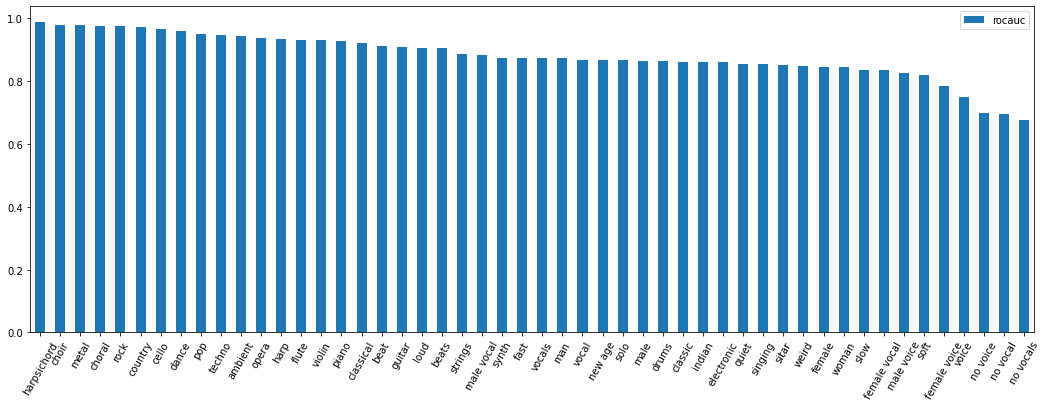

In [24]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task